Cumulative variance explained by 50 PCA components: 0.14
For n_clusters=2, Silhouette Score=0.27441390654836123
For n_clusters=3, Silhouette Score=0.19325512537760087
For n_clusters=4, Silhouette Score=0.18324128676953705
For n_clusters=5, Silhouette Score=0.1809893053845915
For n_clusters=6, Silhouette Score=0.19521327197626295
For n_clusters=7, Silhouette Score=0.19369644790846238
For n_clusters=8, Silhouette Score=0.19245886232225912
For n_clusters=9, Silhouette Score=0.19450983289541007
For n_clusters=10, Silhouette Score=0.18814645498855034
For n_clusters=11, Silhouette Score=0.19117050756276538
For n_clusters=12, Silhouette Score=0.1892113230849825
For n_clusters=13, Silhouette Score=0.18024540261273242
For n_clusters=14, Silhouette Score=0.1837821979601091
For n_clusters=15, Silhouette Score=0.17385536132152685
For n_clusters=16, Silhouette Score=0.17181413191437145
For n_clusters=17, Silhouette Score=0.17314353252148146
For n_clusters=18, Silhouette Score=0.17100052888890813
Fo

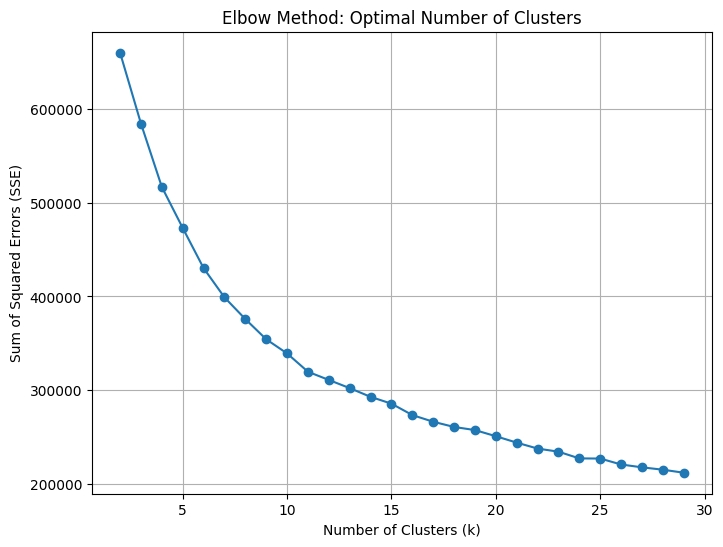

Davies-Bouldin Index: 1.37
Calinski-Harabasz Index: 379.00
Silhouette Score: 0.19


/Users/alexthorpe/Documents/GitHub/prompt-library/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/alexthorpe/Documents/GitHub/prompt-library/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


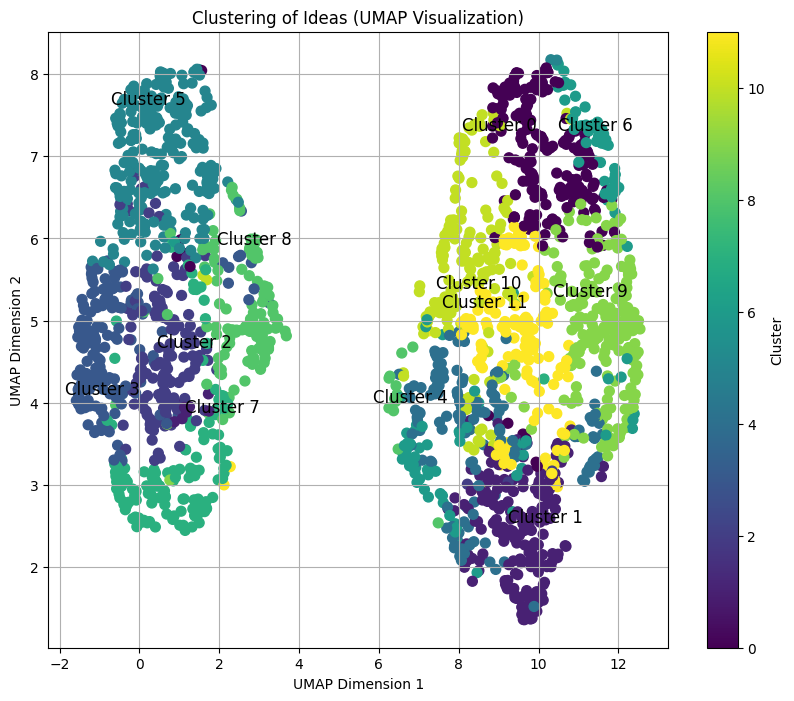

Clustering results saved to /Users/alexthorpe/Desktop/clustering_results.csv


In [19]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
from dotenv import load_dotenv
from pinecone.grpc import PineconeGRPC as Pinecone

# Step 1: Load environment variables
load_dotenv()

# Set up Pinecone API key and initialize
pinecone_api_key = os.getenv("PINECONE_API_KEY")
if not pinecone_api_key:
    raise ValueError("PINECONE_API_KEY is not set in the .env file")

pc = Pinecone(api_key=pinecone_api_key)

index_name = 'idea-index'
namespace = os.getenv("PINECONE_NAMESPACE")
index = pc.Index(index_name)

# Step 2: Fetch embeddings from Pinecone
batch_size = 500
all_ids = []
for ids in index.list(namespace=namespace):
    all_ids.extend(ids)

embeddings = []
for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    embeddings.extend([vector["values"] for vector in response["vectors"].values()])

# Convert embeddings to a NumPy array
embeddings = np.array(embeddings, dtype=np.float32)

# Step 3: Fetch metadata from Pinecone
metadata_dict = {}
for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    for vector_id, vector_data in response['vectors'].items():
        metadata_dict[vector_id] = vector_data['metadata']

# Convert metadata to a DataFrame
metadata_df = pd.DataFrame.from_dict(metadata_dict, orient='index')
metadata_df.reset_index(inplace=True)
metadata_df.rename(columns={'index': 'vector_id'}, inplace=True)

# Step 4: Combine text fields for NLP processing
metadata_df['combined_text'] = metadata_df[['description', 'title', 'comments']].fillna('').agg(' '.join, axis=1)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=500), 'combined_text'),
        ('category', OneHotEncoder(handle_unknown='ignore'), ['category'])
    ],
    remainder='drop',
    verbose_feature_names_out=False  # Optional if verbose warnings appear
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
transformed_metadata = pipeline.fit_transform(metadata_df)

# Combine embeddings with transformed metadata
scaled_embeddings = StandardScaler().fit_transform(embeddings)
combined_data = np.hstack([scaled_embeddings, transformed_metadata.toarray()])

# Step 5: Dimensionality reduction with PCA
pca = PCA(n_components=5, random_state=42)
reduced_data = pca.fit_transform(combined_data)

# Check explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Cumulative variance explained by 50 PCA components: {explained_variance:.2f}")

# Step 6: Determine optimal clusters using Elbow Method
sse = []
k_values = range(2, 30)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    sse.append(kmeans.inertia_)
    labels = kmeans.fit_predict(reduced_data)
    silhouette_avg = silhouette_score(reduced_data, labels)
    print(f"For n_clusters={k}, Silhouette Score={silhouette_avg}")

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(k_values, sse, marker='o')
plt.title("Elbow Method: Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid(True)
plt.show()

# Step 7: Clustering with K-Means
optimal_clusters = 12  # Adjust based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(reduced_data)

# Step 8: Evaluate clustering
davies_bouldin = davies_bouldin_score(reduced_data, labels)
calinski_harabasz = calinski_harabasz_score(reduced_data, labels)
silhouette = silhouette_score(reduced_data, labels)

print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")  # Lower is better
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")  # Higher is better
print(f"Silhouette Score: {silhouette:.2f}")  # Higher is better

# Step 9: Visualization with UMAP
umap = UMAP(n_components=2, random_state=42)
umap_results = umap.fit_transform(reduced_data)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(scatter, label="Cluster")
plt.title("Clustering of Ideas (UMAP Visualization)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)

# Annotate clusters
for i in range(optimal_clusters):
    cluster_indices = np.where(labels == i)[0]
    plt.text(umap_results[cluster_indices[0], 0], umap_results[cluster_indices[0], 1],
             f"Cluster {i}", color='black', fontsize=12, ha='center', va='center')

plt.show()

# Step 10: Save results
metadata_df['Cluster'] = labels
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "clustering_results.csv")
metadata_df.to_csv(desktop_path, index=False)
print(f"Clustering results saved to {desktop_path}")


Clustering Results:

Cluster 0: Issues related to visibility and syncing across components (e.g., items not appearing in search, challenges of maintaining consistency across submissions).
Cluster 1: Feedback and user engagement features (e.g., feedback on voting behaviors, Slack integration for evaluations).
Cluster 2: Weighted scoring and pipeline notifications.
Cluster 3: Administrative restrictions and assignment configurations.
Cluster 4: Customization of views and resolving CSS/UI issues.
Cluster 5: Tagging and metadata automation.
Cluster 6: Language selection, admin onboarding, and platform analytics.
Cluster 7: Notification and action handling across initiatives.
Cluster 8: Access management and permissions for communities and challenges.
Cluster 9: Workflow enhancements and roadmap development tools.
Cluster 10: End-user surveys and better participant reporting.
Cluster 11: Simplification of setup and interface design improvements.
Cluster 12: Editing permissions and voting enhancements.
Cluster 13: General UI/UX design issues and cleanup.
Cluster 14: Consistency in functionality and idea creation tools.